# **LSGI524** *URBAN AND GEOSPATIAL BIG DATA ANALYTICS* Assignment 2

##   Data Loading and Preprocessing

In [5]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn")

client = Client(n_workers=4)
print(dgpd.__version__)
client


v0.3.1


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52731/status,
Dashboard: http://127.0.0.1:52731/status,Workers: 4
Total threads: 16,Total memory: 15.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52733,Workers: 4
Dashboard: http://127.0.0.1:52731/status,Total threads: 16
Started: Just now,Total memory: 15.69 GiB
Comm: tcp://127.0.0.1:52761,Total threads: 4
Dashboard: http://127.0.0.1:52762/status,Memory: 3.92 GiB
Nanny: tcp://127.0.0.1:52736,


####  Define functions for data-preprocessing

In [6]:
def convert_timezone(utc_df: pd.DataFrame,
                     target_tz: str = "America/New_York",
                     columns: list = ["pick_up_time", "drop_off_time"]):
    new_timezone_df = utc_df.copy()
    start_col, end_col = columns[0], columns[1]
    new_timezone_df[start_col] = new_timezone_df[start_col].dt.tz_convert(
        target_tz)
    new_timezone_df[end_col] = new_timezone_df[end_col].dt.tz_convert(
        target_tz)
    return new_timezone_df

def intersection_to_road(roads,intersections_raw):
    from shapely.geometry import LineString
    merge_start = roads.merge(intersections_raw, left_on="node1", right_on="id")
    merge_start['geom_node1'] = gpd.points_from_xy(merge_start['longitude'],
                                                merge_start['latitude'])
    merge_start = merge_start[['node1', 'node2', 'geom_node1']]
    merge_start = merge_start.merge(intersections_raw,
                                    left_on="node2",
                                    right_on="id")
    merge_start['geom_node2'] = gpd.points_from_xy(merge_start['longitude'],
                                                merge_start['latitude'])
    merge_start = merge_start[['node1', 'node2', 'geom_node1', 'geom_node2']]
    merge_start['geometry'] = merge_start.apply(
        lambda x: LineString([x['geom_node1'], x['geom_node2']]), axis=1)
    merge_start = merge_start[['node1', 'node2', 'geometry']]
    road_gdf = gpd.GeoDataFrame(merge_start,
                                        geometry="geometry",
                                        crs="epsg:4326")
    return road_gdf


####  Loading data and pre-processing

In [7]:
# raw data
raw_taxi_df = dd.read_csv(r'./raw_data/taxi_id.csv',
                 blocksize=64e6,
                 names=[
                     'taxi_id', 'pick_up_time', 'drop_off_time',
                     'pick_up_intersection', 'drop_of_intersection'
                 ])
roads = pd.read_csv(r'./raw_data/roads.csv',index_col=None,names=['node1',"node2","geom"])
intersections_raw = pd.read_csv(r'./raw_data/intersections.csv',
                                names=['id', 'latitude', 'longitude'])
boundary = gpd.read_file(r"./raw_data/taxi_zones.shp")

# Unix epoch timestamp correspond to UTC
raw_taxi_df['pick_up_time'] = dd.to_datetime(raw_taxi_df['pick_up_time'],
                                             unit='s',
                                             utc=True)
raw_taxi_df['drop_off_time'] = dd.to_datetime(raw_taxi_df['drop_off_time'],
                                              unit="s",
                                              utc=True)
raw_taxi_df['trip_date'] = raw_taxi_df['pick_up_time'].dt.date

# a copy of raw_df with timezone transforming in datetime field
nytz_df = convert_timezone(raw_taxi_df).drop(
    ['drop_off_time', 'pick_up_intersection', "drop_of_intersection"], axis=1)

# extract trip_date and trip_hour in local time
nytz_df['trip_date'] = nytz_df['pick_up_time'].dt.strftime('%Y-%m-%d')
nytz_df['trip_hour'] = nytz_df['pick_up_time'].dt.strftime('%H')
display(raw_taxi_df.head())
display(nytz_df.head())
display(nytz_df.info)


,taxi_id,pick_up_time,drop_off_time,pick_up_intersection,drop_of_intersection,trip_date
0,1,2011-01-01 00:00:00+00:00,2011-01-01 00:14:08+00:00,952,2021,2011-01-01
1,2,2011-01-01 00:00:01+00:00,2011-01-01 00:08:43+00:00,1372,2815,2011-01-01
2,3,2011-01-01 00:00:03+00:00,2011-01-01 00:04:36+00:00,856,1149,2011-01-01
3,4,2011-01-01 00:00:04+00:00,2011-01-01 00:04:59+00:00,2060,1956,2011-01-01
4,5,2011-01-01 00:00:07+00:00,2011-01-01 00:19:19+00:00,2506,1332,2011-01-01


,taxi_id,pick_up_time,trip_date,trip_hour
0,1,2010-12-31 19:00:00-05:00,2010-12-31,19
1,2,2010-12-31 19:00:01-05:00,2010-12-31,19
2,3,2010-12-31 19:00:03-05:00,2010-12-31,19
3,4,2010-12-31 19:00:04-05:00,2010-12-31,19
4,5,2010-12-31 19:00:07-05:00,2010-12-31,19


<bound method DataFrame.info of Dask DataFrame Structure:
               taxi_id                      pick_up_time trip_date trip_hour
npartitions=84                                                              
                 int64  datetime64[ns, America/New_York]    object    object
                   ...                               ...       ...       ...
...                ...                               ...       ...       ...
                   ...                               ...       ...       ...
                   ...                               ...       ...       ...
Dask Name: assign, 23 graph layers>

## Task 1

### Task 1.1 How many unique taxis?

In [8]:
print(
    f"Number of unique taxi: {raw_taxi_df['taxi_id'].nunique().compute()}"
)
# The answer is 13385


Number of unique taxi: 13385


### Task 1.2 How many trips are recorded?

In [9]:
print(f"Trips before dropping NA: {len(raw_taxi_df.index.compute())}")
print(f"Trips after dropping NA: {len(raw_taxi_df.dropna().index.compute())}")
# Number of trips: 147800095

Trips before dropping NA: 147800095
Trips after dropping NA: 147800095


## Task 2

### Task 2.1 The distribution of the number of trips per taxi and the top performers

In [10]:
trips_distribution_per_taxi = raw_taxi_df.groupby(['taxi_id']).count()[[
    'pick_up_time'
]].sort_values(by='pick_up_time', ascending=False).compute().rename(
    {"pick_up_time": "trip_counts"}, axis=1)

print("\n++++++++++Top Performers++++++++++\n")
print(trips_distribution_per_taxi.head(10))



++++++++++Top Performers++++++++++

         trip_counts
taxi_id             
4816           22842
3341           20859
914            20684
2543           20135
2159           20098
8013           20040
2761           19938
3558           19826
462            19611
7112           19528


### Task 2.2 Defining functions and data distribution visualization

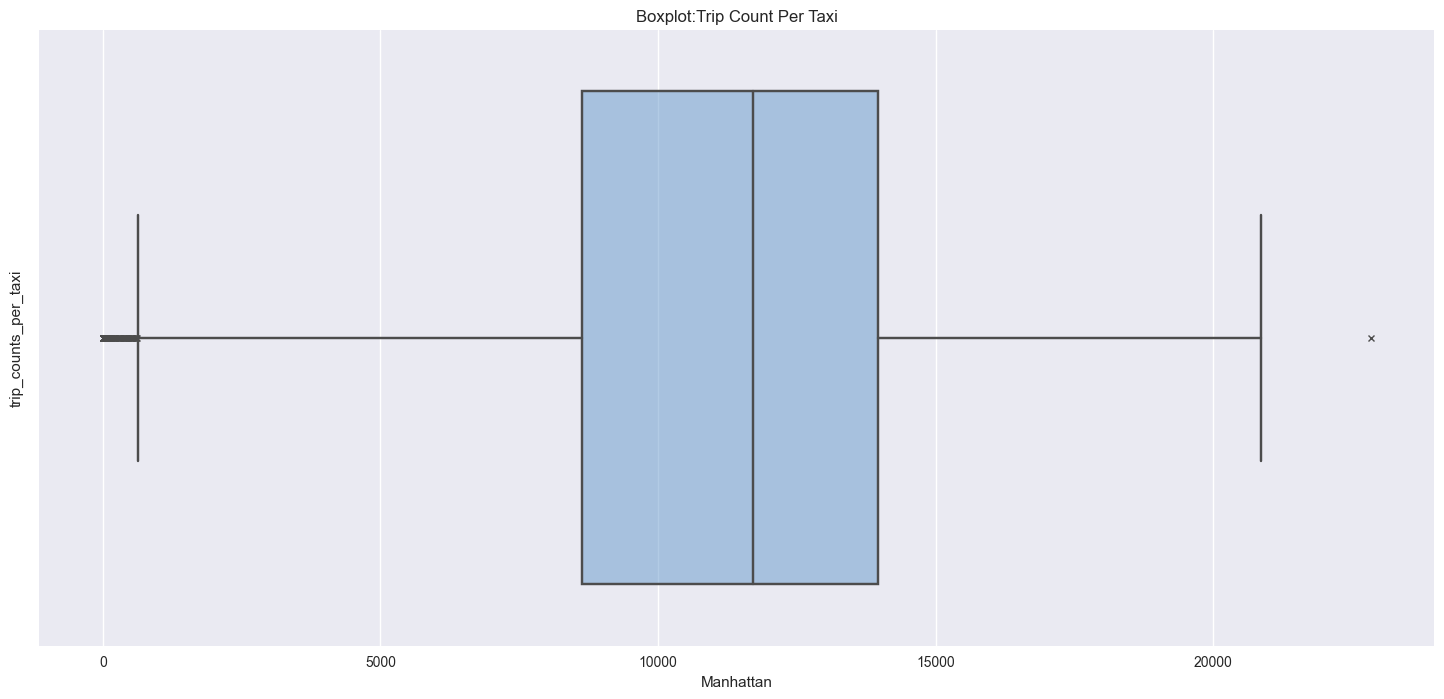

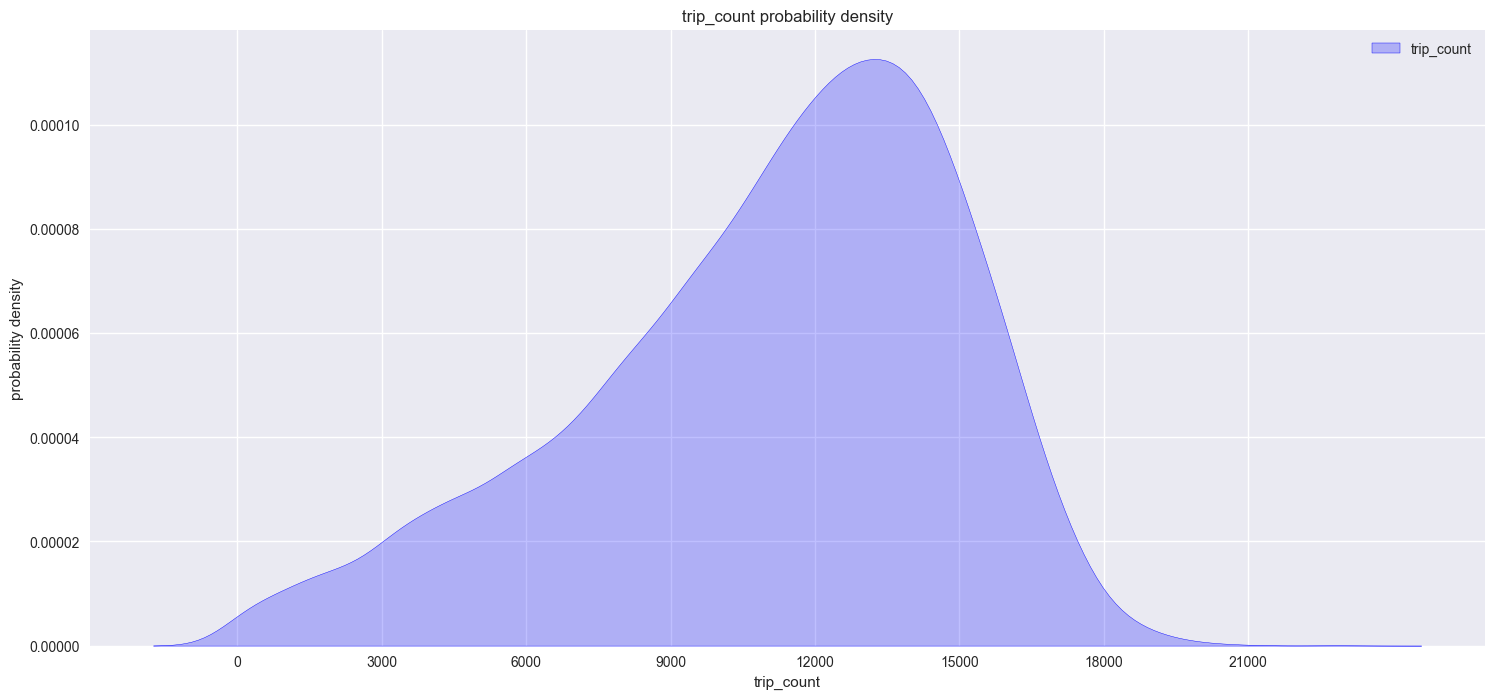

In [11]:
def plot_box(df:pd.DataFrame,field:str, xlabel: str, ylabel: str,
                 title: str, **kwargs):
    """simple box plot
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')
    fig = plt.figure(1, (18, 8), dpi=100)
    ax = plt.subplot(111)
    sns.boxplot(x=field,
                data=df,
                ax=ax,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def plot_kde(df: pd.DataFrame, topic="trip_counts"):
    """probability distribution plotting

    Args:
        df (pd.DataFrame): df containing data
        topic (str, optional): topic. Defaults to "distance".

    Raises:
        TypeError: _description_
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig = plt.figure(1,(18,8),dpi=100)
    ax = plt.subplot(111)
    if topic == "trip_counts":
        column = "trip_counts"
        xlabel = "trip_count"
        ylabel = "probability density"
        title = "trip_count probability density"
        step = 3000
    else:
        raise TypeError(f"Topic {topic} Not Found.")

    sns.kdeplot(
        data=df[column],
        fill=True,
        color="b",
        label=xlabel,
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, round(df[column].max()), step))
    plt.show()


plot_box(trips_distribution_per_taxi.reset_index(),"trip_counts","Manhattan","trip_counts_per_taxi","Boxplot:Trip Count Per Taxi")
plot_kde(trips_distribution_per_taxi.reset_index(),"trip_counts")



## Task 3 Daily Trip count and pattern

#### 3.1 Defining trips_number flow in one-year period and visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


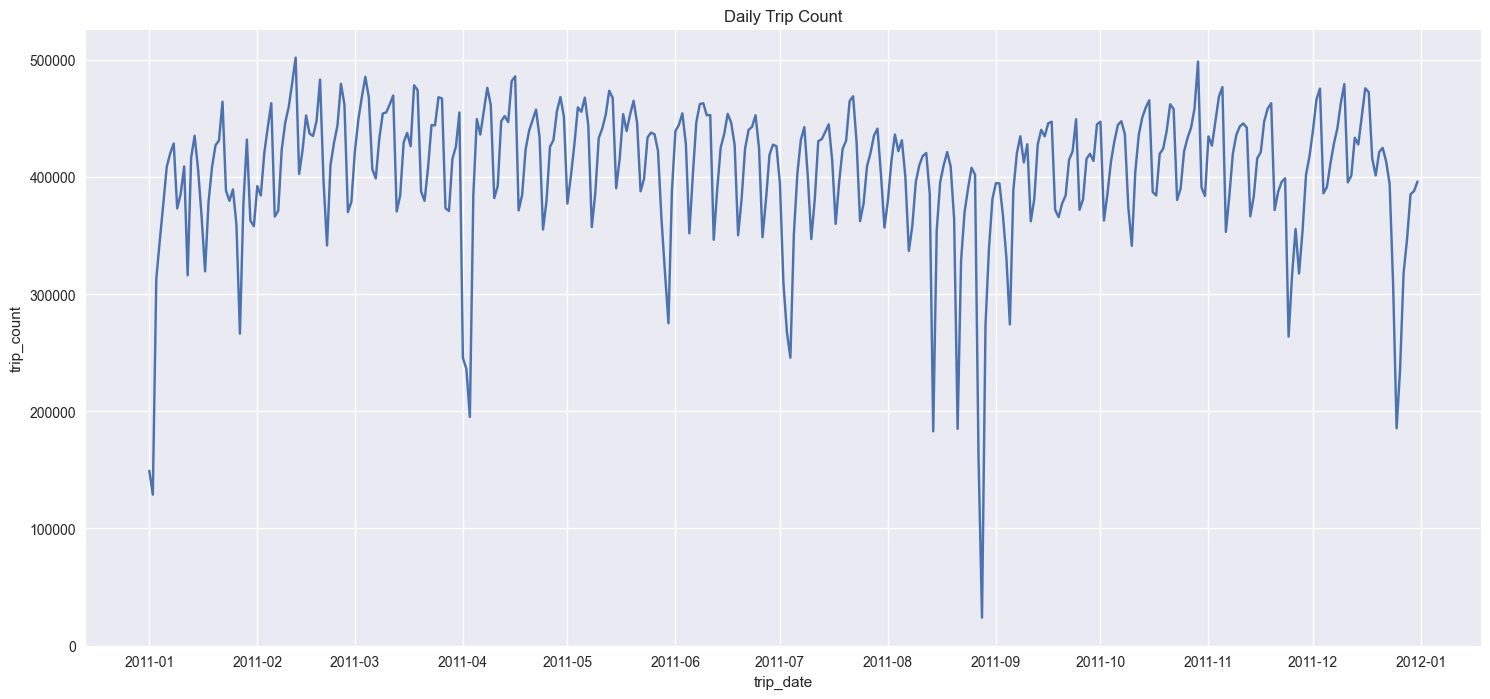

In [12]:
def plot_trend(
    df: pd.DataFrame,
    data_field="trip_count",
    x_column="trip_date",
    y_column="trip_count",
):
    """line chart, showing time trend

    Args:
        df (pd.DataFrame): dataframe
        data_field (str, optional): data field. 
        Defaults to "trip_count".
        x_column (str, optional): time field. 
        Defaults to "trip_date".
        y_column (str, optional): ylabel. 
        Defaults to "trip_count".
    """
    import matplotlib.dates as mdates

    # create figure
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    # plot
    sns.lineplot(
        y=data_field,
        x=x_column,
        data=df,
        # color="b",
        markers=True,
        ax=ax
    )

    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title("Daily Trip Count")
    plt.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.show()


trips_daily_counts = raw_taxi_df.groupby(['trip_date']).count()[[
    'taxi_id'
]].compute().rename({"taxi_id": "trip_count"}, axis=1)
trips_daily_counts

plot_trend(trips_daily_counts)


## Task 4. Distribution of the number of trips **Departure&Arrival** aggregated by station

#### 4.1 data-preprocessing

In [13]:
# generating gdf recording the number of trips departure and arrival based on stations.

# 1.For each trip, refering its departure station and count
merged_ddf = raw_taxi_df.merge(intersections_raw,
                               left_on="pick_up_intersection",
                               right_on="id")
departure_counter = merged_ddf.groupby(['pick_up_intersection']).count()[['taxi_id']].compute().rename({"taxi_id":"departure_counts"},axis = 1 )

# 2.For each trip, refering its arrival station and count
merged_ddf2 = raw_taxi_df.merge(intersections_raw,
                                left_on="drop_of_intersection",
                                right_on="id")
arrival_counter = merged_ddf2.groupby(["drop_of_intersection"]).count()[[
    'taxi_id'
]].compute().rename({"taxi_id": "arrival_counts"}, axis=1)

# Aftering grouping, generating geo-info for each station
departure_gdf = departure_counter.merge(intersections_raw,
                                        left_index=True,
                                        right_on="id")
departure_gdf['geometry'] = gpd.points_from_xy(departure_gdf["longitude"],
                                               departure_gdf['latitude'],
                                               crs="epsg:4326")
departure_gdf = gpd.GeoDataFrame(departure_gdf)

arrival_gdf = arrival_counter.merge(intersections_raw,
                                    left_index=True,
                                    right_on="id")
arrival_gdf['geometry'] = gpd.points_from_xy(arrival_gdf['longitude'],
                                             arrival_gdf['latitude'],
                                             crs="epsg:4326")
arrival_gdf = gpd.GeoDataFrame(arrival_gdf)


#### 4.2 Spatial distribution visualization based on stations

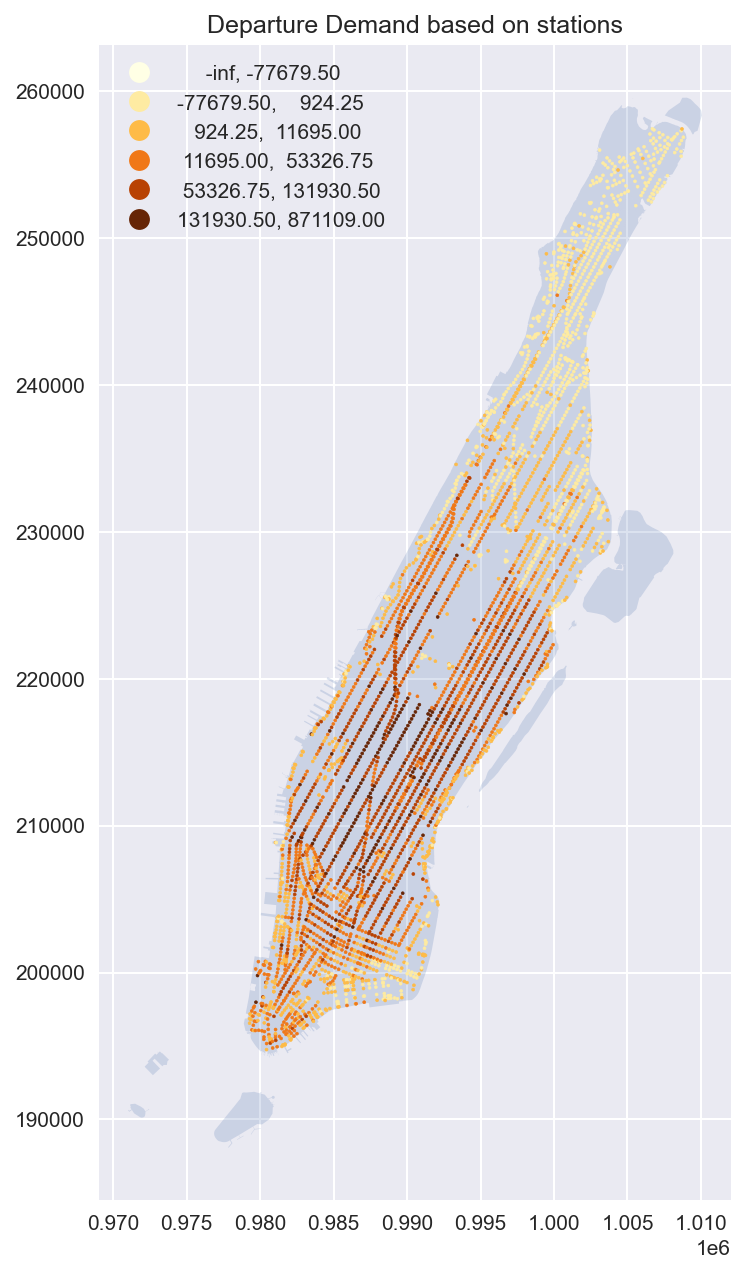

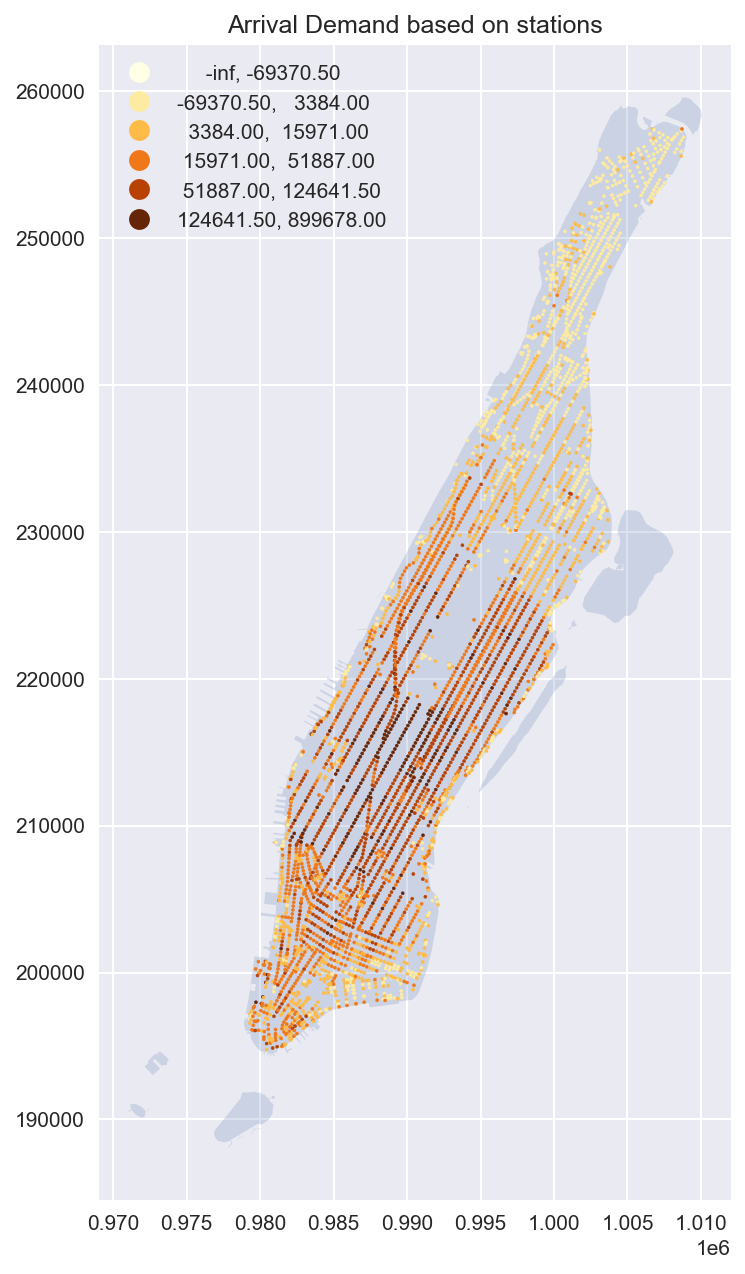

In [14]:
def plot_departure_demand_station():
    fig = plt.figure(1,(16,10),dpi = 150)
    ax = plt.subplot(111)
    boundary[boundary['borough'] == "Manhattan"].plot(ax=ax, alpha=0.2)
    departure_gdf.to_crs(f"epsg:{boundary.crs.to_epsg()}").plot(
        ax=ax,
        column="departure_counts",
        markersize=2,
        cmap="YlOrBr",
        legend=True,
        scheme="BoxPlot",
        k=4,
    )
    plt.title("Departure Demand based on stations")
    plt.show()

def plot_arrival_demand_station():
    fig = plt.figure(1, (16, 10), dpi=150)
    ax = plt.subplot(111)
    boundary[boundary['borough'] == "Manhattan"].plot(ax=ax, alpha=0.2)
    arrival_gdf.to_crs(f"epsg:{boundary.crs.to_epsg()}").plot(
        ax=ax,
        column="arrival_counts",
        markersize=2,
        cmap="YlOrBr",
        legend=True,
        scheme="BoxPlot",
        k=4,
    )
    plt.title("Arrival Demand based on stations")
    plt.show()
plot_departure_demand_station()
plot_arrival_demand_station()


#### 4.3 Spatial distribution visualization based on roads

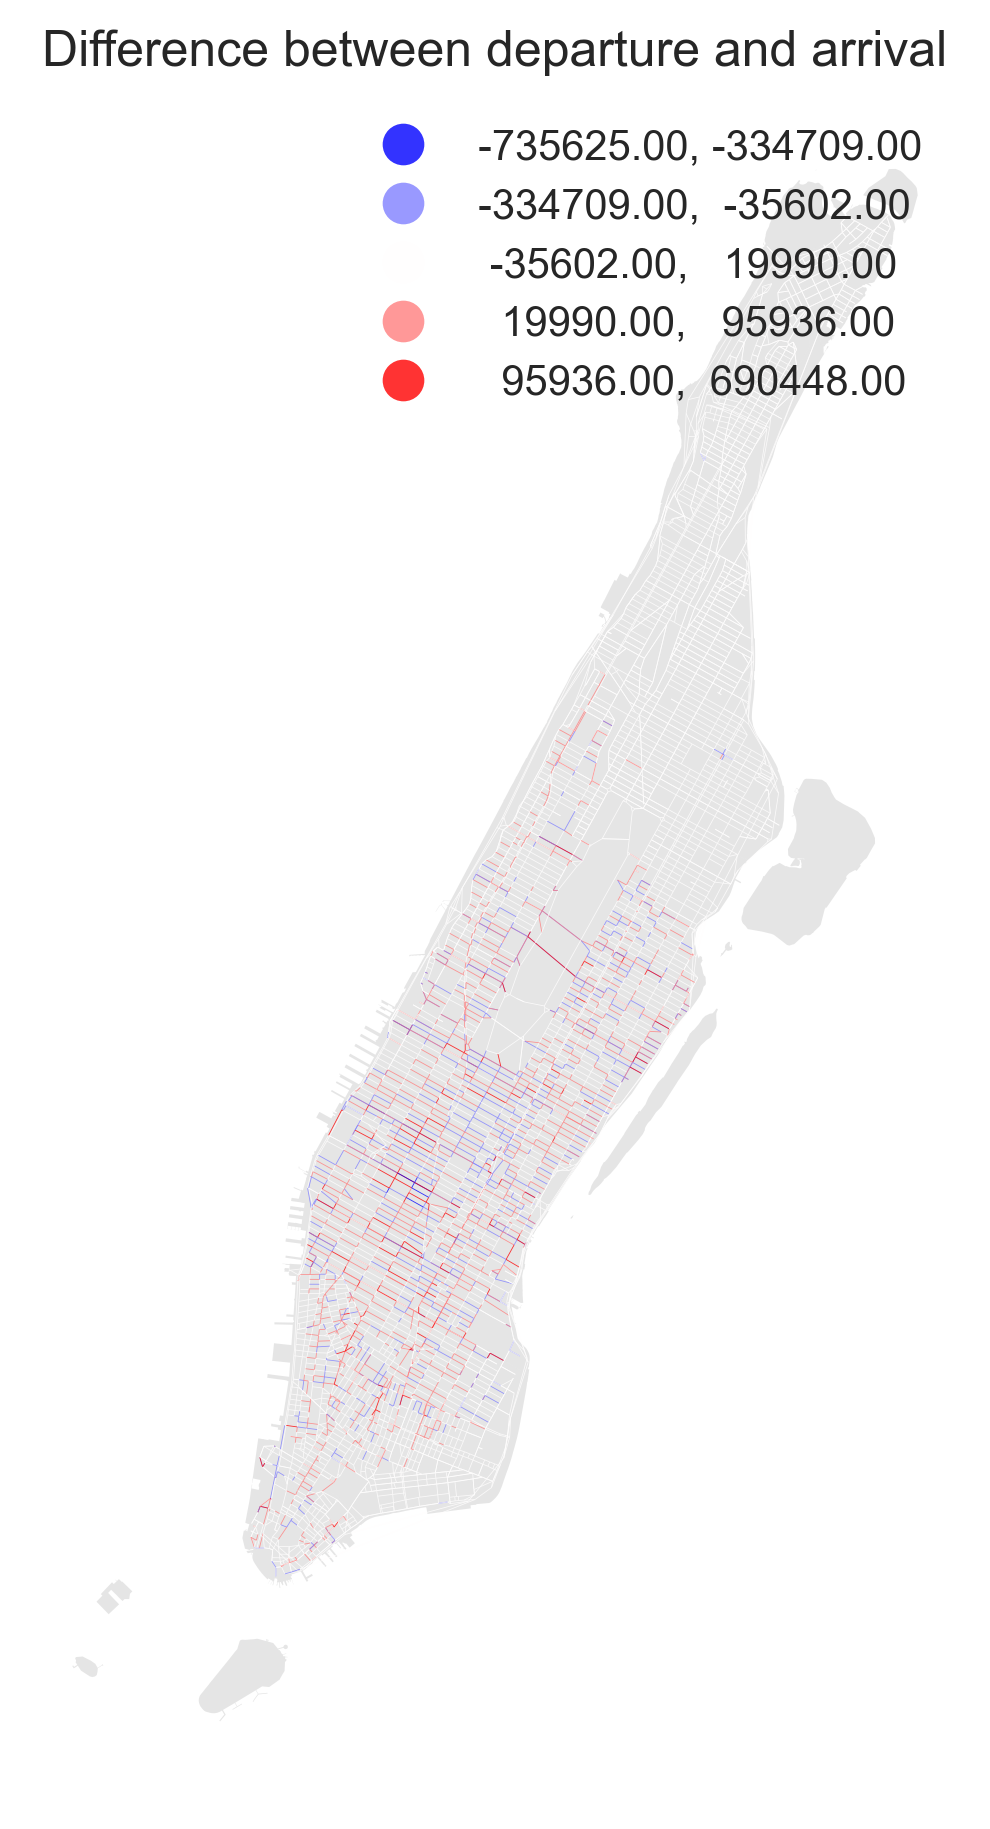

In [15]:
roads_intersection = intersection_to_road(roads=roads, intersections_raw=intersections_raw)
roads_recorder = roads_intersection.merge(departure_gdf[['id',"departure_counts"]],left_on = "node1",right_on = "id").drop(['id'],axis=1).merge(arrival_gdf[['id',"arrival_counts"]],left_on = "node2",right_on="id").drop(['id'],axis = 1)
roads_recorder['demand_diff']  = roads_recorder['departure_counts'] - roads_recorder['arrival_counts']

fig, ax = plt.subplots(1, 1, figsize=(4, 8), dpi=300)
boundary[boundary['borough'] == "Manhattan"].to_crs("epsg:4326").plot(
    ax=ax, alpha=0.2, facecolor="grey")
roads_recorder.plot(ax=ax,
                    column="demand_diff",
                    cmap="bwr",
                    linewidth=0.2,
                    scheme='NaturalBreaks',
                    alpha=0.8,
                    legend=True,
                    )

plt.title("Difference between departure and arrival")
plt.axis("off")
plt.show()


#### 4.4 probability density distribution

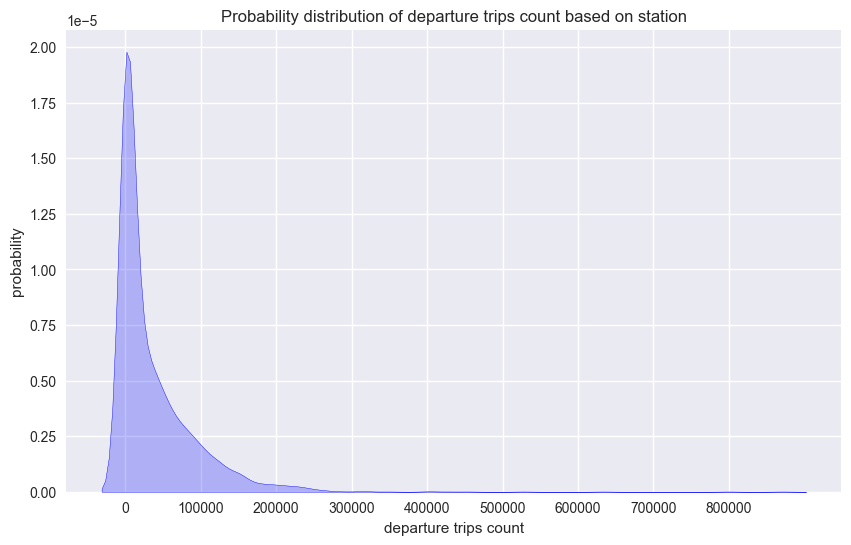

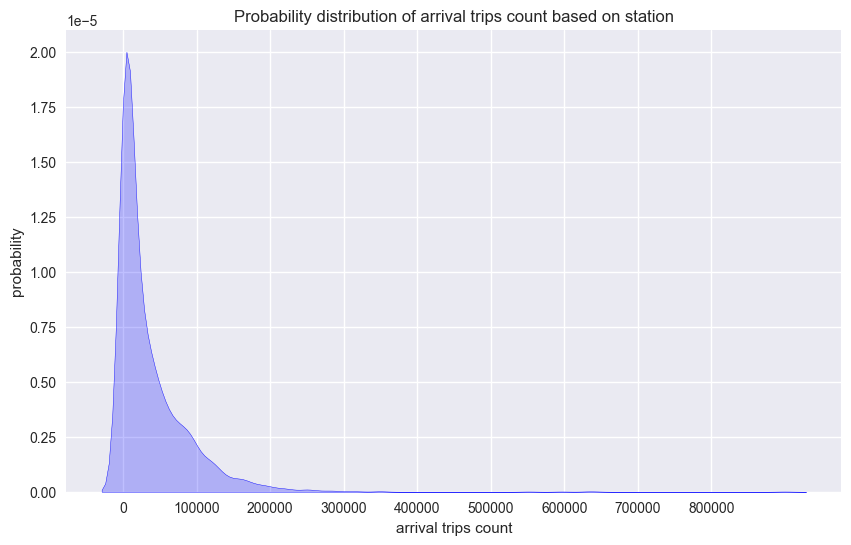

In [16]:
def plot_station_arrival_departure_kde(df, column, xlabel):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)

    sns.kdeplot(data=df[column], shade=True, color='b',ax=ax)
    plt.xlabel(xlabel)
    plt.ylabel("probability")

    plt.title(f"Probability distribution of {xlabel} based on station")
    plt.xticks(range(0,round(departure_gdf['departure_counts'].max()),100000))
    plt.show()


plot_station_arrival_departure_kde(departure_gdf,"departure_counts","departure trips count")
plot_station_arrival_departure_kde(arrival_gdf, "arrival_counts",
                                   "arrival trips count")


## Task 5. Number of trips over a day

In [17]:
def plot_trend(
    df: pd.DataFrame,
    data_field="trip_count",
    x_column="trip_date",
    y_column="trip_count",
    emphasis_range=None,
    date = None
):
    """line chart, showing time trend

    Args:
        df (pd.DataFrame): dataframe
        data_field (str, optional): data field. 
        Defaults to "trip_count".
        x_column (str, optional): time field. 
        Defaults to "trip_date".
        y_column (str, optional): ylabel. 
        Defaults to "trip_count".
        palette (list, optional): color space. 
        Defaults to ["#FF6B6B", "#FFD166", "#06D6A0", "#277DA1", "#FEAA40"].
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    macaron_colors = ["#FF6B6B", "#FFD166", "#06D6A0", "#277DA1", "#FEAA40"]
    # create figure
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    # plot
    sns.lineplot(
        y=data_field,
        x=x_column,
        data=df,
        # color="b",
        markers=True,
        ax=ax)
    plt.xticks(range(0, 24, 1))
    if len(emphasis_range) >= 1:
        plt.axvspan(
            emphasis_range[0][0],
            emphasis_range[0][1],
            alpha=0.2,
            color=macaron_colors[0],
            label=
            f"Rush Hour ({emphasis_range[0][0]}:00-{emphasis_range[0][1]}:00)",
        )
        plt.axvspan(
            emphasis_range[1][0],
            emphasis_range[1][1],
            alpha=0.2,
            color=macaron_colors[1],
            label=
            f"Rush Hour ({emphasis_range[1][0]}:00-{emphasis_range[1][1]}:00)",
        )
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    if date:
        plt.title(f"Daily Trip Count for {date}")
    else:
        plt.title(f"Daily Trip Count ")
    plt.legend()
    plt.show()


#### 5.1 Randomly selecting dates

In [18]:
# 1. randomly select 3 days in the dataset range
date_sample1, date_sample2, date_sample3 = pd.to_datetime(
    (pd.date_range('2011-01-01',
                   periods=364).to_series().sample(
                       n=3).to_list())).strftime('%Y-%m-%d')
date_sample1


'2011-10-01'

#### 5.2 groupping by date and hour

In [19]:
# calculating the groupping result, groupping rules:by=["trip_date", "trip_hour"]

hourly_trend_in_days = nytz_df[(nytz_df["trip_date"] == date_sample1) |
                       (nytz_df["trip_date"] == date_sample2) |
                       (nytz_df["trip_date"] == date_sample3)][[
                           'trip_date', "trip_hour", "taxi_id"
                       ]].groupby(
                           by=["trip_date", "trip_hour"]).count().rename(
                               columns={"taxi_id": "trip_count"})
_hourly_groupping_res = hourly_trend_in_days.compute()
_hourly_groupping_res = _hourly_groupping_res.reset_index()
display(_hourly_groupping_res.head(24))


,trip_date,trip_hour,trip_count
0,2011-01-04,00,2462
1,2011-01-04,01,8645
2,2011-01-04,02,17633
3,2011-01-04,03,23443
4,2011-01-04,04,21199
5,2011-01-04,05,16701
6,2011-01-04,06,16304
7,2011-01-04,07,17383
8,2011-01-04,08,17156
9,2011-01-04,09,18557


#### 5.3 visualize trips number flow in different hour in one day(randomly selected)

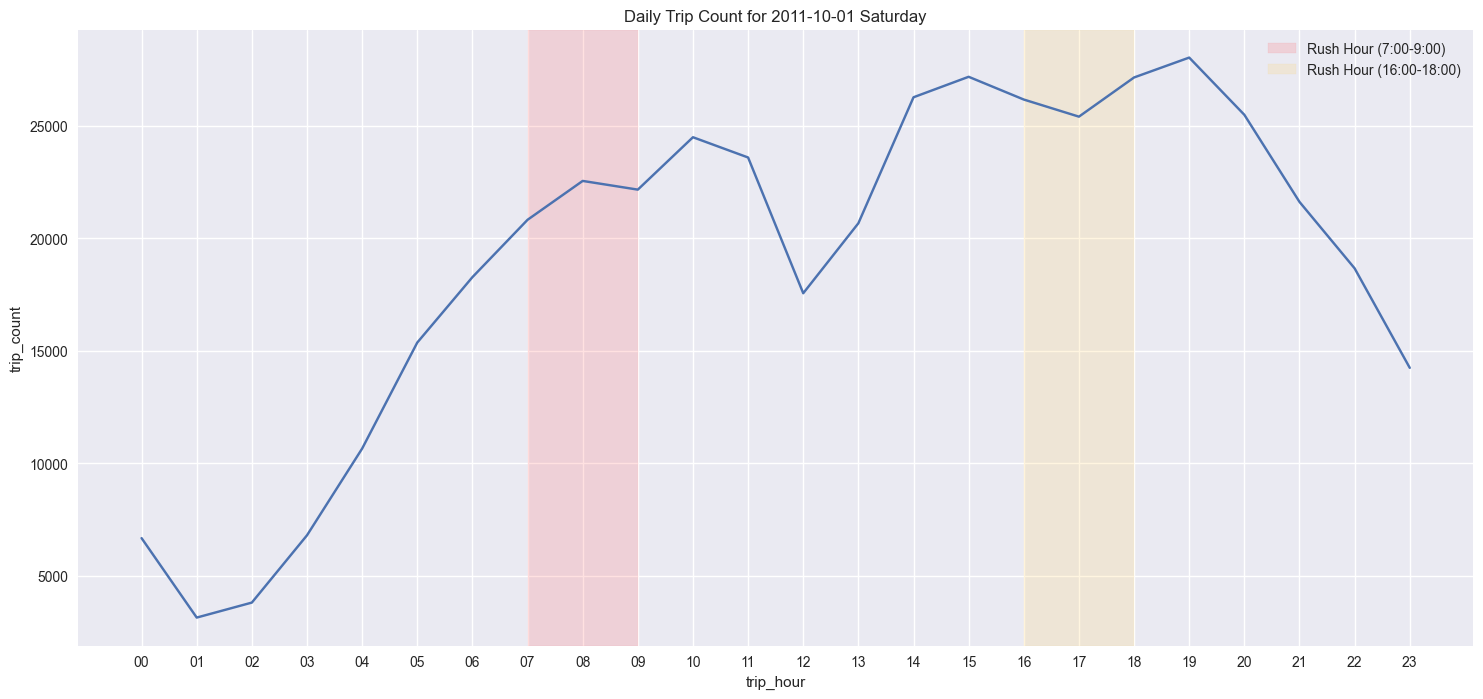

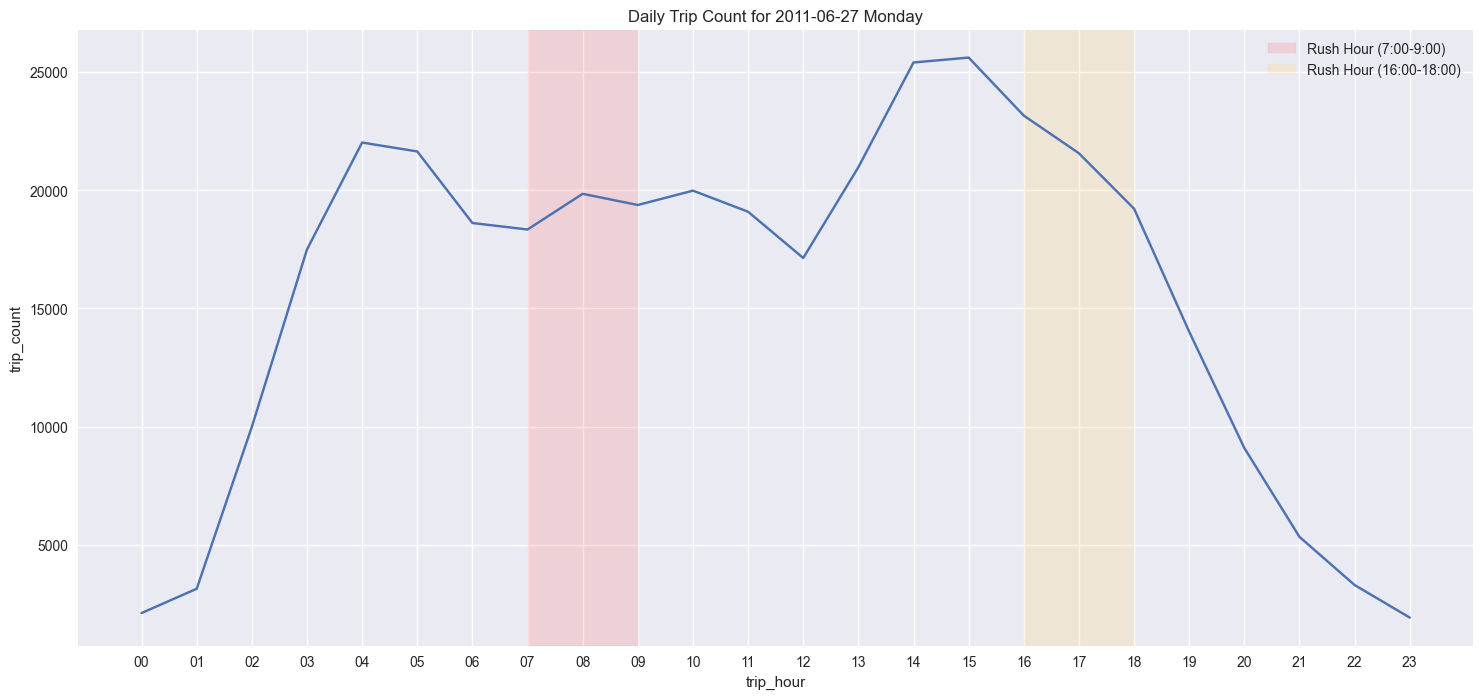

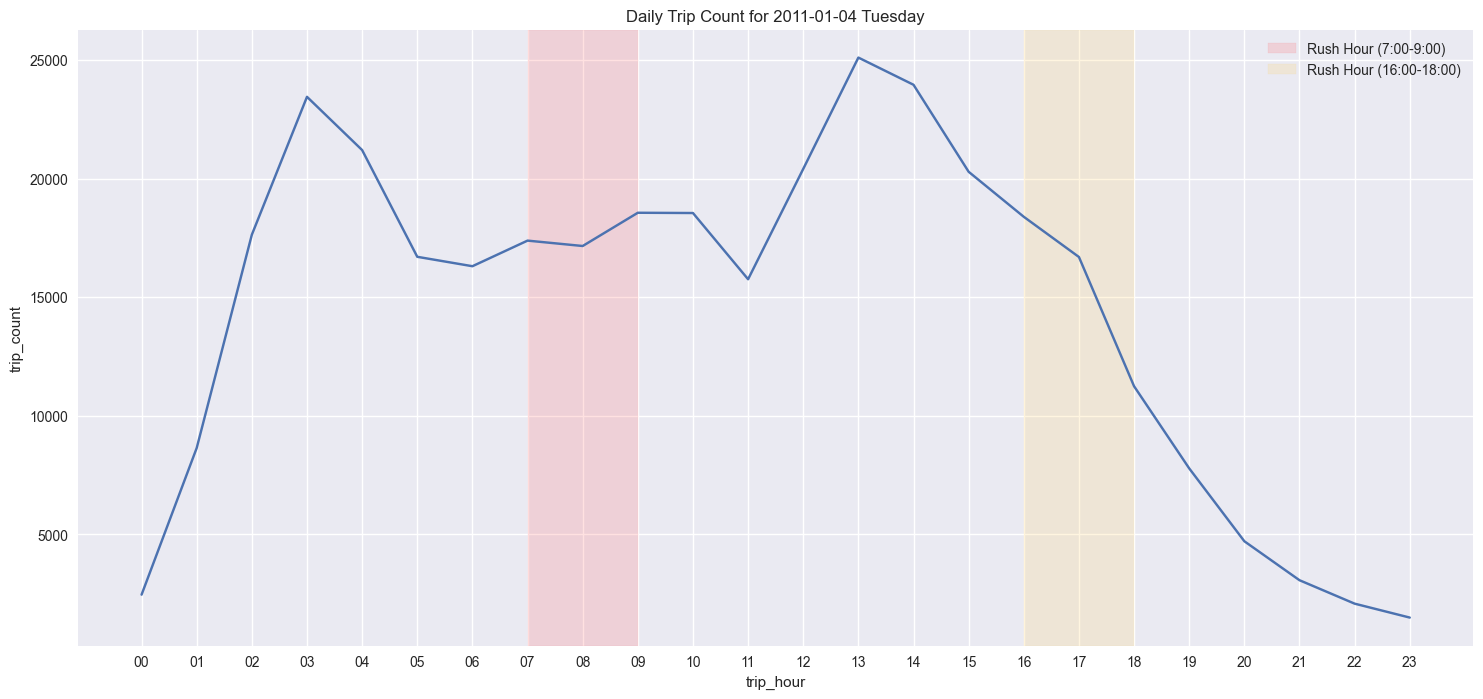

In [20]:
# loop the dates randomly selected and plot them individually
from datetime import datetime
import calendar
for _date in [date_sample1,date_sample2,date_sample3]:
    _date_data = _hourly_groupping_res[_hourly_groupping_res['trip_date'] ==
                                       _date][['trip_count', "trip_hour"]]

    date_week = pd.to_datetime(_date).weekday()
    plot_trend(_date_data,
               data_field="trip_count",
               x_column="trip_hour",
               y_column="trip_count",
               emphasis_range=[(7, 9), (16, 18)],
               date=_date + " " + calendar.day_name[date_week])


## Task 6. Probability distribution of trip distance and trip duration

#### 6.1 defining functions for visualizations

In [21]:
def plot_travel_distance_kde(series):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)

    sns.kdeplot(data=series, shade=True, color='b', ax=ax)
    plt.xlabel("Travel Distance")
    plt.ylabel("probability")

    plt.title(f"Probability distribution of travel distance (1% Sample)")
    plt.xticks(range(0, round(series.max()), 5000))
    plt.show()


def plot_travel_time_kde(series):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    data = series[series < series.quantile(0.99)]
    sns.kdeplot(data=data, shade=True, color='b', ax=ax)
    plt.xlabel("Travel Time")
    plt.ylabel("probability")

    plt.title(f"Probability distribution of travel time (1% Sample)")
    plt.xticks(
        range(0, round(series.quantile(0.99)),
              round(series.quantile(0.99) / 10)))
    plt.show()


#### 6.2 visualizing the probability distributio of travel distance

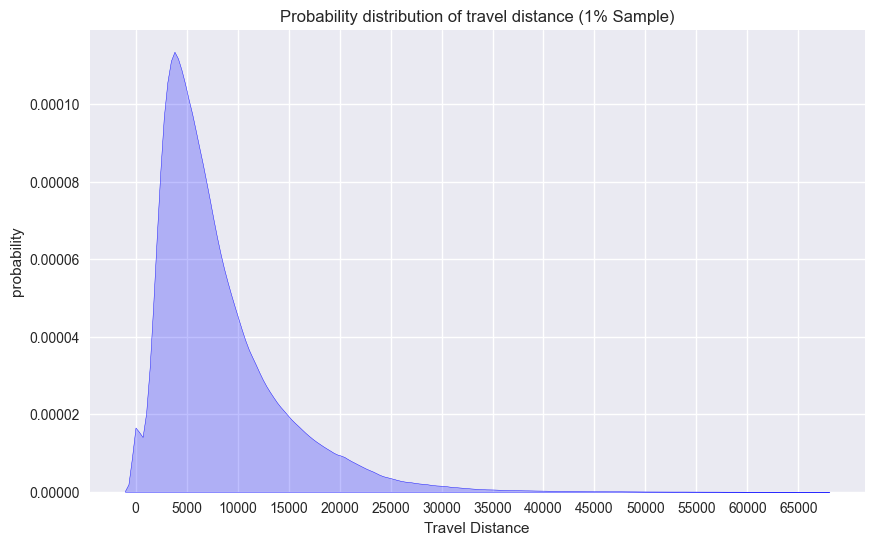

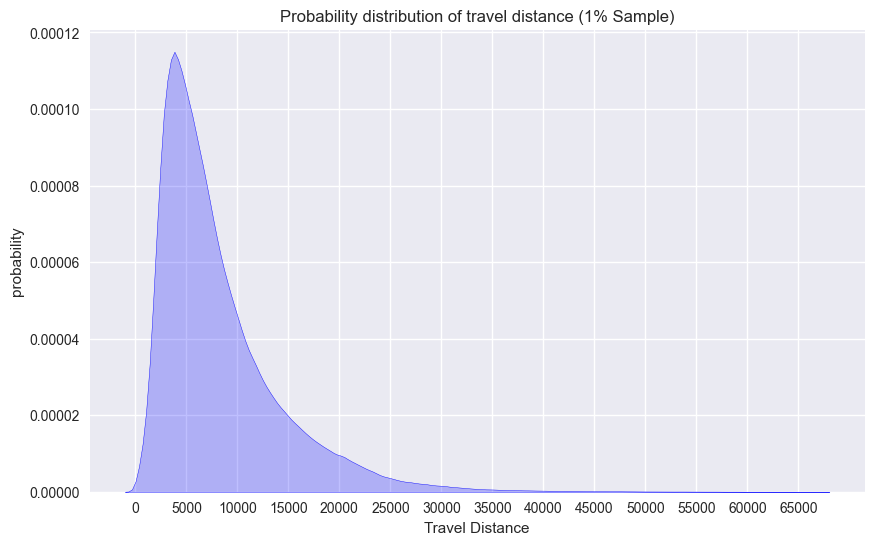

In [26]:
# 1. calculating the distance between departure station and arrival station for each trip
intersections_raw['geometry'] = gpd.points_from_xy(
    intersections_raw['longitude'], intersections_raw['latitude'])
intersections_geom = gpd.GeoDataFrame(
    intersections_raw[['id', "geometry"]],
    crs="epsg:4326").to_crs("epsg:2263").set_index("id")

geom_related_df = raw_taxi_df[['pick_up_intersection', "drop_of_intersection"]]

dgdf_departure_arrival = dgpd.from_dask_dataframe(geom_related_df.merge(intersections_geom,left_on="pick_up_intersection",right_index=True).merge(intersections_geom,left_on='drop_of_intersection',right_index =  True)[['geometry_x',"geometry_y"]])
dgdf_trip_distance = dgdf_departure_arrival['geometry_x'].distance(
    dgdf_departure_arrival['geometry_y']).compute()

# Down sampling to 1% of the data due to the comlexity in calculating probability density.
trip_distance_sample = dgdf_trip_distance.sample(int(0.01 * len(dgdf_trip_distance)),
                                   random_state=42)
# visualizing probability distribution of trip_distance
plot_travel_distance_kde(trip_distance_sample)

# remove meaningless data (departure location == arrival location)
trip_distance_sample_without0 = trip_distance_sample[trip_distance_sample > 0]
plot_travel_distance_kde(trip_distance_sample_without0)


#### 6.3 visualizing the probability distribution of travel time

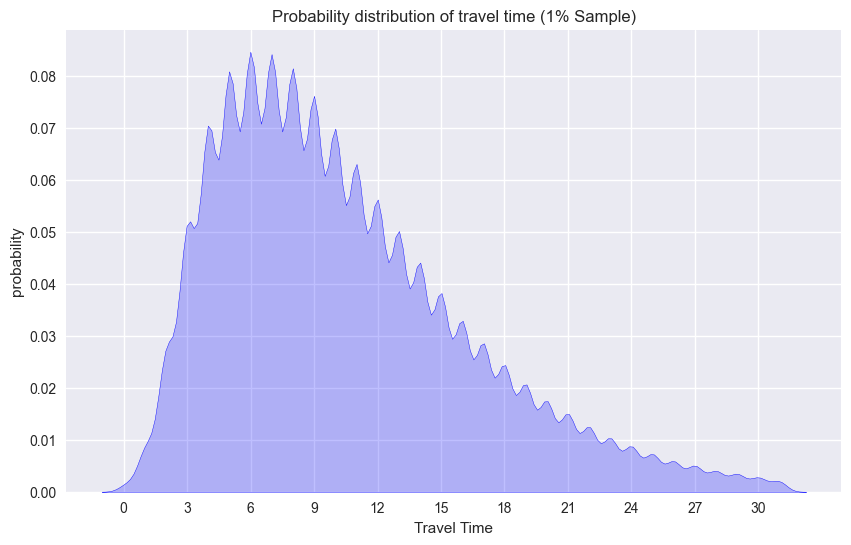

In [24]:
# calculating travel duration by <end_time - start_time>
travel_time_ddf = (raw_taxi_df['drop_off_time'] -
                   raw_taxi_df['pick_up_time']).compute()

# calculating trip duration and converting into minutes
trip_duration_sample = (travel_time_ddf.dt.seconds / 60).round(2).sample(
    int(0.01 * len(travel_time_ddf)), random_state=42)
_trip_duration_sample = trip_duration_sample[
    trip_duration_sample <= trip_duration_sample.quantile(0.999)].reset_index(
        drop=True)

# plotting
plot_travel_time_kde(_trip_duration_sample)


#### 6.4 Others: exploring why the probability distribution of travel time is so weird (not smooth at all)

In [25]:
# groupping the travel time and sorting them from high to low
groupping_by_mintue = _trip_duration_sample.to_frame(
    name="minutes").reset_index().groupby("minutes").count().rename(
        {
            "index": "count"
        }, axis=1).sort_values(by="count", ascending=False).head(50)
groupping_by_mintue

# You will find that most travel times are approximated to minutes in integer, i don't know why?

,count
minutes,
6.00,55292
7.00,55176
8.00,53689
5.00,52579
9.00,50700
10.00,46869
4.00,45143
11.00,41838
12.00,37566
